In [36]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [37]:
from src import soporte_ajuste as sa

En este notebook vamos a aplicar métodos de ensamble, tanto de Bagging como de Bugging

In [38]:
df = pd.read_csv("datos/encoding.csv", index_col=0)

Vamos a aplicar algoritmos de elevado coste computacional así que vamos a coger un sample de 3000 muestras para acortar tiempos de ejecudción.

In [39]:
df=df.sample(3000)

In [40]:
X = df.drop("price", axis = 1)
y = df[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42, shuffle=True)

### Random forest

In [41]:
# Definimos un diccionario con nuestros hiper parámetros
params_rf = {
    'n_estimators': [150],
    'max_depth': [7, 10, 15],
    'min_samples_split': [10, 15, 20, 25], 
    'min_samples_leaf': [10, 15, 20, 25], 
    'max_leaf_nodes': [100, 200, 300] 
}

modelo_rf = RandomForestRegressor(random_state=42, bootstrap=True) 

grid_search_rf = GridSearchCV(modelo_rf,
                              params_rf,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_rf.fit(X_train, y_train["price"].values) 
modelo_final_rf= grid_search_rf.best_estimator_
modelo_final_rf

RandomForestRegressor(max_depth=15, max_leaf_nodes=100, min_samples_leaf=10,
                      min_samples_split=10, n_estimators=150, random_state=42)

In [42]:
y_pred_test = modelo_final_rf.predict(X_test)
y_pred_train = modelo_final_rf.predict(X_train)

In [43]:
df_metricas_rf = sa.metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_rf

,r2_score,MAE,MSE,RMSE
train,0.632272,2156.719586,3.364958e+07,5800.826225
test,0.617970,2441.389791,1.706925e+07,4131.495155


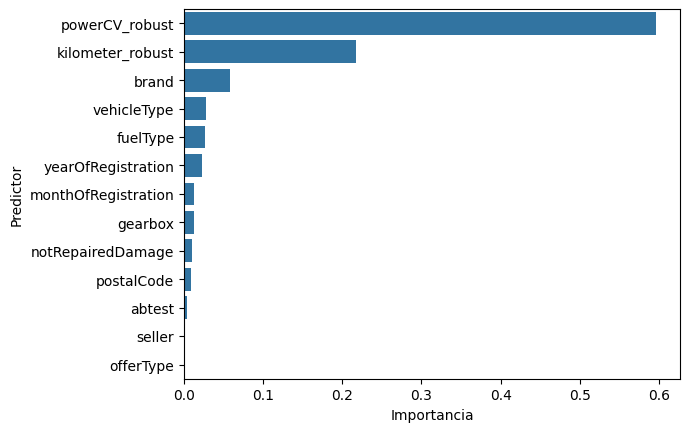

In [44]:
importancias = modelo_final_rf.feature_importances_
importancia_rf = pd.DataFrame({"Predictor": X_train.columns, "Importancia": importancias})
importancia_rf = importancia_rf.sort_values(by="Importancia", ascending=False)
sns.barplot(y = "Predictor", x = "Importancia", data = importancia_rf);

### GradientBoosting

In [45]:
np.set_printoptions(suppress= True)
# Establecemos un diccionario con los hiperparámetros
params_gb = {
    'n_estimators': [150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [100, 200, 300]  
}

In [46]:
modelo_gb = GradientBoostingRegressor(random_state=42)
random_search_gb= GridSearchCV(modelo_gb,
                             params_gb,
                             cv=5,
                             scoring= "neg_mean_squared_error",
                             n_jobs=-1)

random_search_gb.fit(X_train,y_train["price"].values)   
modelo_final_gb= random_search_gb.best_estimator_
modelo_final_gb

GradientBoostingRegressor(learning_rate=0.2, max_depth=15, min_samples_leaf=100,
                          n_estimators=150, random_state=42)

In [47]:
y_pred_test = modelo_final_gb.predict(X_test)
y_pred_train = modelo_final_gb.predict(X_train)

In [48]:
df_metricas_gb = sa.metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_gb

,r2_score,MAE,MSE,RMSE
train,0.707198,2050.561282,2.679330e+07,5176.224515
test,0.572747,2640.186869,1.908982e+07,4369.189667


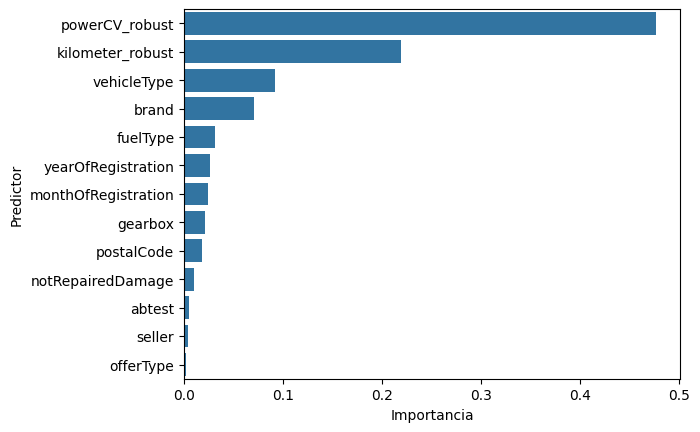

In [49]:
importancias = modelo_final_gb.feature_importances_
importancia_gb = pd.DataFrame({"Predictor": X_train.columns, "Importancia": importancias})
importancia_gb = importancia_gb.sort_values(by="Importancia", ascending=False)
sns.barplot(y = "Predictor", x = "Importancia", data = importancia_gb);

### XGBRegressor

In [50]:
np.set_printoptions(suppress= True)
# Establecemos un diccionario con los hiperparámetros
params_xg = {
    'max_depth': [15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [150],
    'min_child_weight': [1, 2, 4],
    'colsample_bytree': [0.8, 1.0] 
}

In [51]:
modelo_xg= XGBRegressor(random_state=42, eval_metric= "rmse")
random_search_xg= GridSearchCV(modelo_xg,
                             params_xg,
                             cv=5,
                             scoring= "neg_mean_squared_error",
                             n_jobs=-1)

random_search_xg.fit(X_train,y_train["price"].values)   
modelo_final_xg= random_search_xg.best_estimator_
modelo_final_xg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [52]:
y_pred_test = modelo_final_xg.predict(X_test)
y_pred_train = modelo_final_xg.predict(X_train)

In [53]:
df_metricas_xg = sa.metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_xg

,r2_score,MAE,MSE,RMSE
train,1.000000,0.627438,9.650786e+00,3.106571
test,0.492415,2627.550234,2.267912e+07,4762.259970


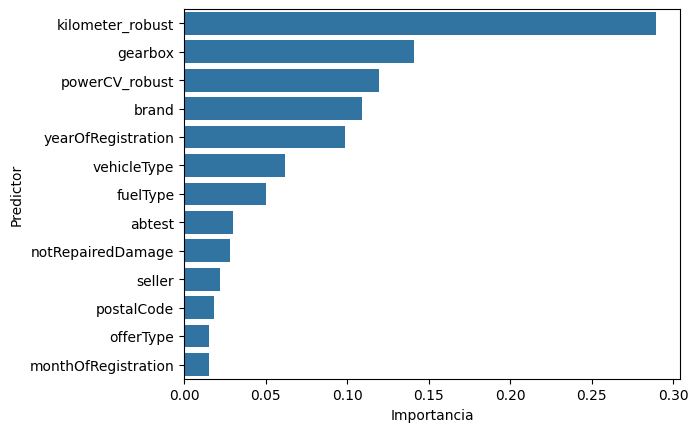

In [54]:
importancias = modelo_final_xg.feature_importances_
importancia_xg = pd.DataFrame({"Predictor": X_train.columns, "Importancia": importancias})
importancia_xg = importancia_xg.sort_values(by="Importancia", ascending=False)
sns.barplot(y = "Predictor", x = "Importancia", data = importancia_xg);